In this notebook, we will implement MAML for the sine regressors from [Finn et al (2017)]( https://arxiv.org/abs/1703.03400).

In [1]:
import torch
import torch.nn as nn
import numpy as np
from collections import OrderedDict
from src.tasks import Sine_Task, Sine_Task_Distribution

import matplotlib.pyplot as plt

## Model

To implement MAML in Pytorch, we will need a model that can be easily parametrised with a set of weights that's distinct from the model's own parameters. Having these weights distinct from the model.parameters() allows us to easily make differentiable gradient updates within the inner loop.

In [2]:
class MAMLModel(nn.Module):
    def __init__(self):
        super(MAMLModel, self).__init__()
        self.model = nn.Sequential(OrderedDict([
            ('l1', nn.Linear(1,40)),
            ('relu1', nn.ReLU()),
            ('l2', nn.Linear(40,40)),
            ('relu2', nn.ReLU()),
            ('l3', nn.Linear(40,1))
        ]))
        
    def forward(self, x):
        return self.model(x)
    
    def parameterised(self, x, weights):
        # like forward, but uses ``weights`` instead of ``model.parameters()``
        # it'd be nice if this could be generated automatically for any nn.Module...
        x = nn.functional.linear(x, weights[0], weights[1])
        x = nn.functional.relu(x)
        x = nn.functional.linear(x, weights[2], weights[3])
        x = nn.functional.relu(x)
        x = nn.functional.linear(x, weights[4], weights[5])
        return x
                        

## MAML

This code implements MAML for supervised few-shot learning.

It is probably not performance-optimal, but was designed to reproduce the behaviour in the paper while being maximally simple.

In [3]:
class MAML():
    def __init__(self, model, tasks, inner_lr, meta_lr, K=10, inner_steps=1, tasks_per_meta_batch=1000):
        
        # important objects
        self.tasks = tasks
        self.model = model
        self.weights = list(model.parameters()) # the maml weights we will be meta-optimising
        self.criterion = nn.MSELoss()
        self.meta_optimiser = torch.optim.Adam(self.weights, meta_lr)
        
        # hyperparameters
        self.inner_lr = inner_lr
        self.meta_lr = meta_lr
        self.K = K
        self.inner_steps = inner_steps # with the current design of MAML, >1 is unlikely to work well 
        self.tasks_per_meta_batch = tasks_per_meta_batch 
        
        # metrics
        self.plot_every = 10
        self.print_every = 500
        self.meta_losses = []
    
    def inner_loop(self, task):
        # reset inner model to current maml weights
        temp_weights = [w.clone() for w in self.weights]
        
        # perform training on data sampled from task
        X, y = task.sample_data(self.K)
        for step in range(self.inner_steps):
            loss = self.criterion(self.model.parameterised(X, temp_weights), y) / self.K
            
            # compute grad and update inner loop weights
            grad = torch.autograd.grad(loss, temp_weights)
            temp_weights = [w - self.inner_lr * g for w, g in zip(temp_weights, grad)]
        
        # sample new data for meta-update and compute loss
        X, y = task.sample_data(self.K)
        loss = self.criterion(self.model.parameterised(X, temp_weights), y) / self.K
        
        return loss
    
    def main_loop(self, num_iterations):
        epoch_loss = 0
        
        for iteration in range(1, num_iterations+1):
            
            # compute meta loss
            meta_loss = 0
            for i in range(self.tasks_per_meta_batch):
                task = self.tasks.sample_task()
                meta_loss += self.inner_loop(task)
            
            # compute meta gradient of loss with respect to maml weights
            meta_grads = torch.autograd.grad(meta_loss, self.weights)
            
            # assign meta gradient to weights and take optimisation step
            for w, g in zip(self.weights, meta_grads):
                w.grad = g
            self.meta_optimiser.step()
            
            # log metrics
            epoch_loss += meta_loss.item() / self.tasks_per_meta_batch
            
            if iteration % self.print_every == 0:
                print("{}/{}. loss: {}".format(iteration, num_iterations, epoch_loss / self.plot_every))
            
            if iteration % self.plot_every == 0:
                self.meta_losses.append(epoch_loss / self.plot_every)
                epoch_loss = 0

In [4]:
tasks = Sine_Task_Distribution(0.1, 5, 0, np.pi, -5, 5)
maml = MAML(MAMLModel(), tasks, inner_lr=0.01, meta_lr=0.001)

In [5]:
maml.main_loop(num_iterations=10000)

500/10000. loss: 0.2715758575439453
1000/10000. loss: 0.25236947937011717
1500/10000. loss: 0.24671234436035155
2000/10000. loss: 0.23551921691894534
2500/10000. loss: 0.20776873016357422
3000/10000. loss: 0.18328369903564454
3500/10000. loss: 0.14517786712646485
4000/10000. loss: 0.12583503341674807
4500/10000. loss: 0.11470220031738283
5000/10000. loss: 0.10027994689941407
5500/10000. loss: 0.08751449661254884
6000/10000. loss: 0.07236093826293946
6500/10000. loss: 0.06598395233154297
7000/10000. loss: 0.0644005516052246
7500/10000. loss: 0.0598420597076416
8000/10000. loss: 0.057941816329956056
8500/10000. loss: 0.05678546295166015
9000/10000. loss: 0.056896657562255856
9500/10000. loss: 0.054236830520629886
10000/10000. loss: 0.05221614112854004


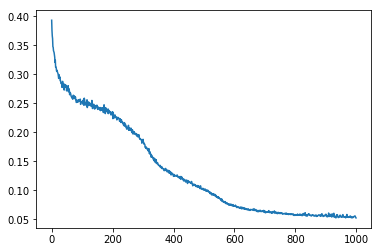

In [6]:
plt.plot(maml.meta_losses)

MAML has a peculiar learning curve. At least on this task distirbution, the brief point of inflection (at 200 on the plot) seems to persist across different hyperparameter choices.

## Testing and Plotting

Now that the model is trained, let's look at how it performs, and compare it to some naive benchmarks.

In [7]:
def loss_on_random_task(initial_model, K, num_steps, optim=torch.optim.SGD):
    """
    trains the model on a random sine task and measures the loss curve.
    
    for each n in num_steps_measured, records the model function after n gradient updates.
    """
    
    # copy MAML model into a new object to preserve MAML weights during training
    model = nn.Sequential(OrderedDict([
        ('l1', nn.Linear(1,40)),
        ('relu1', nn.ReLU()),
        ('l2', nn.Linear(40,40)),
        ('relu2', nn.ReLU()),
        ('l3', nn.Linear(40,1))
    ]))
    model.load_state_dict(initial_model.state_dict())
    criterion = nn.MSELoss()
    optimiser = optim(model.parameters(), 0.01)

    # train model on a random task
    task = tasks.sample_task()
    X, y = task.sample_data(K)
    losses = []
    for step in range(1, num_steps+1):
        loss = criterion(model(X), y) / K
        losses.append(loss.item())

        # compute grad and update inner loop weights
        model.zero_grad()
        loss.backward()
        optimiser.step()
        
    return losses

In [8]:
def average_losses(initial_model, n_samples, K=10, n_steps=10, optim=torch.optim.SGD):
    """
    returns the average learning trajectory of the model trained for ``n_iterations`` over ``n_samples`` tasks
    """

    x = np.linspace(-5, 5, 2) # dummy input for test_on_new_task
    avg_losses = [0] * K
    for i in range(n_samples):
        losses = loss_on_random_task(initial_model, K, n_steps, optim)
        avg_losses = [l + l_new for l, l_new in zip(avg_losses, losses)]
    avg_losses = [l / n_samples for l in avg_losses]
    
    return avg_losses

In [9]:
def mixed_pretrained(iterations=500):
    """
    returns a model pretrained on a selection of ``iterations`` random tasks.
    """
    
    # set up model
    model = nn.Sequential(OrderedDict([
            ('l1', nn.Linear(1,40)),
            ('relu1', nn.ReLU()),
            ('l2', nn.Linear(40,40)),
            ('relu2', nn.ReLU()),
            ('l3', nn.Linear(40,1))
        ]))
    optimiser = torch.optim.Adam(model.parameters(), lr=0.01)
    criterion = nn.MSELoss()
    
    # fit the model
    for i in range(iterations):
        
        model.zero_grad()
        x, y = tasks.sample_task().sample_data(10)
        loss = criterion(model(x), y)
        loss.backward()
        optimiser.step()
        
    return model

In [10]:
pretrained = mixed_pretrained(10000)

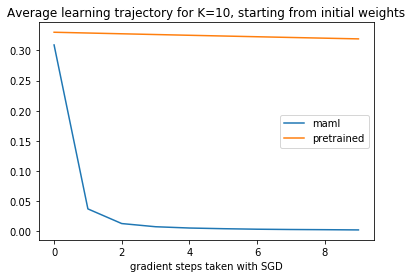

In [11]:
plt.plot(average_losses(maml.model.model, n_samples=5000, K=10), label='maml')
plt.plot(average_losses(pretrained,       n_samples=5000, K=10), label='pretrained')
plt.legend()
plt.title("Average learning trajectory for K=10, starting from initial weights")
plt.xlabel("gradient steps taken with SGD")
plt.show()

Which looks, modulo scale (probably because I divide loss by K) and the learning rate for pretrained, exactly like the plot from the paper.

It is interesting to note that while the MAML weights do not overfit to only work after 1 step, they <i>do</i> fit, if not overfit, to the particular optimiser used in the inner step. Using Adam instead of SGD for the test-time optimiser results in much worse performance:

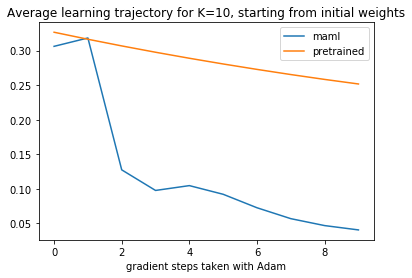

In [13]:
plt.plot(average_losses(maml.model.model, n_samples=5000, K=10, optim=torch.optim.Adam), label='maml')
plt.plot(average_losses(pretrained,       n_samples=5000, K=10, optim=torch.optim.Adam), label='pretrained')
plt.legend()
plt.title("Average learning trajectory for K=10, starting from initial weights")
plt.xlabel("gradient steps taken with Adam")
plt.show()

In [14]:
def model_functions_at_training(initial_model, X, y, sampled_steps, x_axis, optim=torch.optim.SGD, lr=0.01):
    """
    trains the model on X, y and measures the loss curve.
    
    for each n in sampled_steps, records model(x_axis) after n gradient updates.
    """
    
    # copy MAML model into a new object to preserve MAML weights during training
    model = nn.Sequential(OrderedDict([
        ('l1', nn.Linear(1,40)),
        ('relu1', nn.ReLU()),
        ('l2', nn.Linear(40,40)),
        ('relu2', nn.ReLU()),
        ('l3', nn.Linear(40,1))
    ]))
    model.load_state_dict(initial_model.state_dict())
    criterion = nn.MSELoss()
    optimiser = optim(model.parameters(), lr)

    # train model on a random task
    num_steps = max(sampled_steps)
    K = X.shape[0]
    
    losses = []
    outputs = {}
    for step in range(1, num_steps+1):
        loss = criterion(model(X), y) / K
        losses.append(loss.item())

        # compute grad and update inner loop weights
        model.zero_grad()
        loss.backward()
        optimiser.step()

        # plot the model function
        if step in sampled_steps:
            outputs[step] = model(torch.tensor(x_axis, dtype=torch.float).view(-1, 1)).detach().numpy()
            
    outputs['initial'] = initial_model(torch.tensor(x_axis, dtype=torch.float).view(-1, 1)).detach().numpy()
    
    return outputs, losses

In [15]:
def plot_sampled_performance(initial_model, model_name, task, X, y, optim=torch.optim.SGD, lr=0.01):
    
    x_axis = np.linspace(-5, 5, 1000)
    sampled_steps=[1,10]
    outputs, losses = model_functions_at_training(initial_model, 
                                                  X, y, 
                                                  sampled_steps=sampled_steps, 
                                                  x_axis=x_axis, 
                                                  optim=optim, lr=lr)

    plt.figure(figsize=(15,5))
    
    # plot the model functions
    plt.subplot(1, 2, 1)
    
    plt.plot(x_axis, task.true_function(x_axis), '-', color=(0, 0, 1, 0.5), label='true function')
    plt.scatter(X, y, label='data')
    plt.plot(x_axis, outputs['initial'], ':', color=(0.7, 0, 0, 1), label='initial weights')
    
    for step in sampled_steps:
        plt.plot(x_axis, outputs[step], 
                 '-.' if step == 1 else '-', color=(0.5, 0, 0, 1),
                 label='model after {} steps'.format(step))
        
    plt.legend(loc='lower right')
    plt.title("Model fit: {}".format(model_name))

    # plot losses
    plt.subplot(1, 2, 2)
    plt.plot(losses)
    plt.title("Loss over time")
    plt.xlabel("gradient steps taken")
    plt.show()

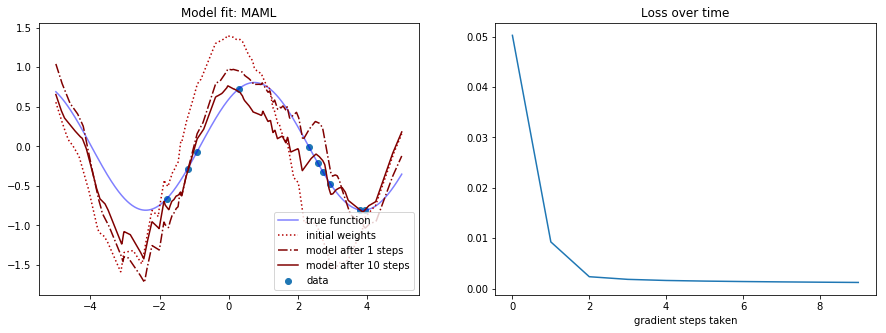

In [16]:
K = 10
task = tasks.sample_task()
X, y = task.sample_data(K)

plot_sampled_performance(maml.model.model, 'MAML', task, X, y)

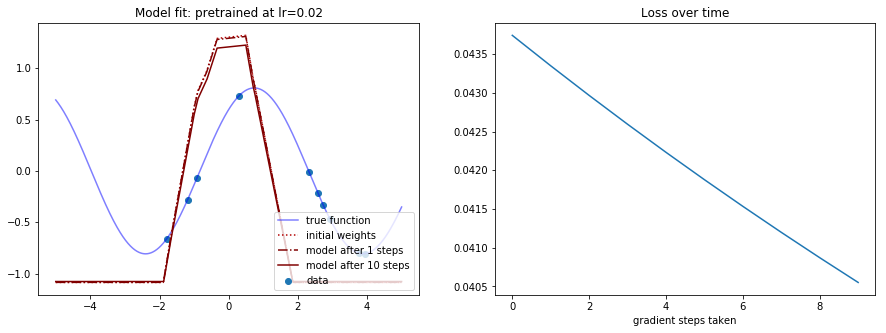

In [17]:
plot_sampled_performance(pretrained, 'pretrained at lr=0.02', task, X, y, lr=0.02)

Performance on K=5 is also good, although less reliable than K=10. This is unsurprising, as we train MAML with K=10. 

It <i>is</i> surprising that despite the uneven loss curves, the model at 10 steps is often well-fit, despite very sparse data.

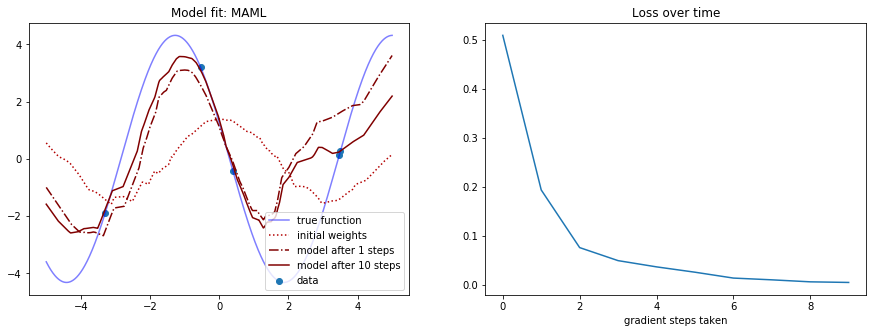

In [18]:
K = 5
task = tasks.sample_task()
X, y = task.sample_data(K)

plot_sampled_performance(maml.model.model, 'MAML', task, X, y)